## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

### Part 4. HAR classification with raw data
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [151]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [152]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from pytorch_model_summary import summary

In [177]:
from tqdm.notebook import tqdm

In [188]:
from IPython.display import clear_output

In [153]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

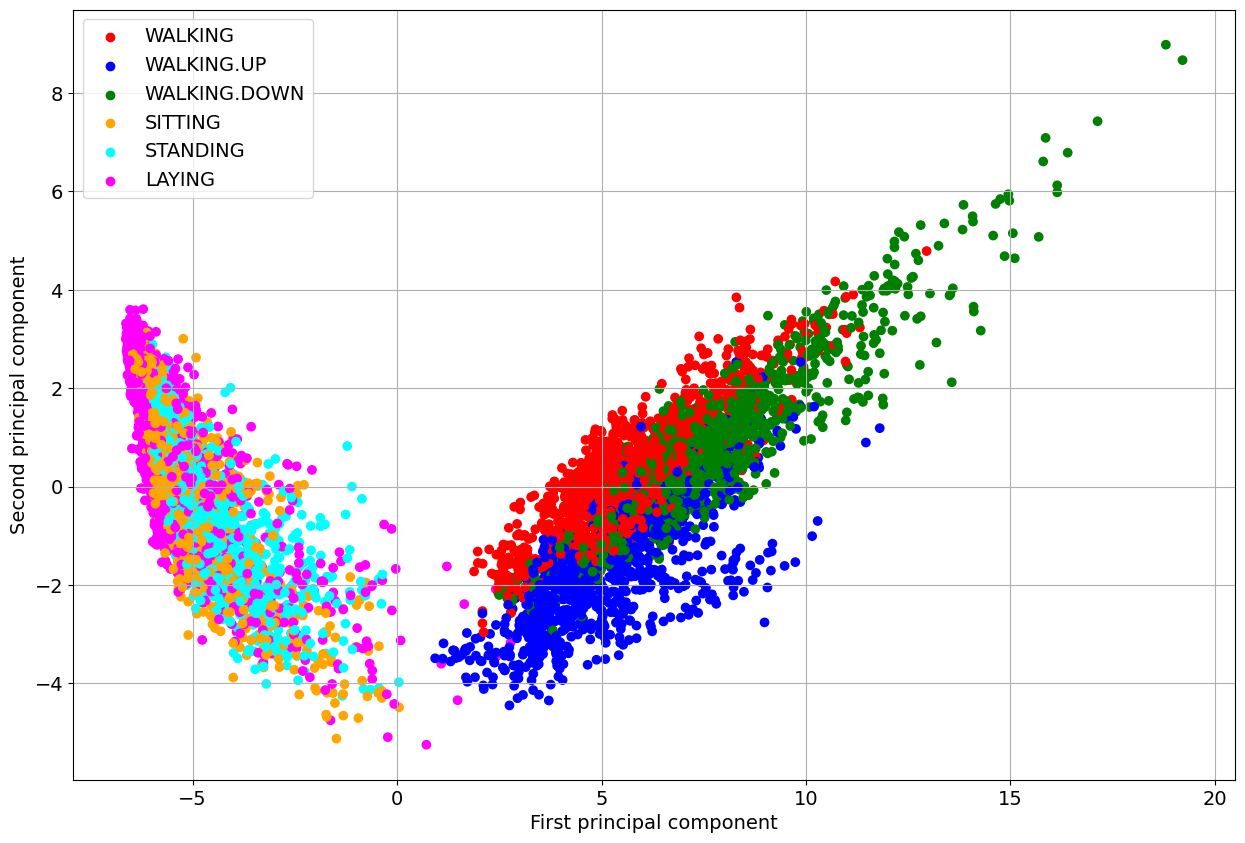

In [154]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [155]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [156]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


In [157]:
np.unique(y_test), X_train.dtype

(array([0, 1, 2, 3, 4, 5], dtype=int32), dtype('float32'))

In [158]:
list(map(type, [X_train, X_test, y_train, y_test]))

[numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray]

#### Построение сети и эксперименты

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__

##### LSTM

Так как в задаче используются последовательные во времени данные, то будет разумно попробовать решить задачу с помощью LSTM.  
Буду использовать библиотеку PyTorch.

In [159]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64).reshape(-1)
y_test = torch.tensor(y_test, dtype=torch.int64).reshape(-1)

In [160]:
# y_train = nn.functional.one_hot(y_train.reshape(-1), num_classes=6)
# y_test = nn.functional.one_hot(y_test.reshape(-1), num_classes=6)

In [161]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [162]:
rand_gen = torch.Generator().manual_seed(42)
train_dataset, valid_dataset = random_split(train_dataset, [0.9, 0.1], rand_gen)

In [163]:
list(map(len, [train_dataset, valid_dataset, test_dataset]))

[6617, 735, 2947]

In [164]:
params = {
    'batch_size': 64,
    'seq_len': 128,
    'n_channels': 9,
    'hidden_size': 64,
    'num_layers': 3,
    'dropout': 0.25,
    'n_classes': 6
}

In [170]:
train_loader = DataLoader(train_dataset, params['batch_size'], shuffle=True)
valid_loader = DataLoader(valid_dataset, params['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, params['batch_size'], shuffle=False)

In [171]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=params['n_channels'],
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            batch_first=True,
            dropout=params['dropout']
        )
        self.linear = nn.Linear(
            params['hidden_size'],
            params['n_classes']
        )
        
    def forward(self, x):
        _, (h, _) = self.lstm(x)
        logits = self.linear(h[-1])
        return logits

In [172]:
model = LSTM()
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_func = nn.CrossEntropyLoss()

In [173]:
print(summary(model, torch.zeros((params['batch_size'], params['seq_len'], params['n_channels']))))

-----------------------------------------------------------------------------------------------
      Layer (type)                                Output Shape         Param #     Tr. Param #
            LSTM-1     [64, 128, 64], [3, 64, 64], [3, 64, 64]          85,760          85,760
          Linear-2                                     [64, 6]             390             390
Total params: 86,150
Trainable params: 86,150
Non-trainable params: 0
-----------------------------------------------------------------------------------------------


In [169]:
# features, targets = next(iter(train_loader))
# logits = model(features)
# print(logits.size(), targets.size())
# loss = loss_func(logits, targets)
# print(loss)
# loss.backward()

torch.Size([64, 6]) torch.Size([64])
tensor(1.7963, grad_fn=<NllLossBackward0>)


In [182]:
loss_history = {
    'train': [],
    'valid': []
}

In [183]:
best_model_params = {
    'valid_loss': float('inf'),
    'epoch': -1
}

In [184]:
def save_checkpoint(model, optimizer, epoch, loss_history, path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_history': loss_history
    }
    torch.save(checkpoint, path)

In [185]:
def load_checkpoint(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss_history = checkpoint['loss_history']
    return epoch, loss_history

In [192]:
def train(model, n_epochs, loss_history, train_loader, valid_loader, best_model_params):
    for epoch in range(n_epochs):
        model.train()
        train_loss_batches = []
        train_loader_tqdm = tqdm(train_loader, 
                                desc=f"Epoch {epoch + 1}/{n_epochs} - Training",
                                leave=False)
        for features, targets in train_loader_tqdm:
            logits = model(features)
            loss = loss_func(logits, targets)
            train_loss_batches.append(loss.detach().cpu().numpy() * features.size()[0])
            loss.backward()
            opt.step()
            opt.zero_grad()
        train_epoch_loss = sum(train_loss_batches) / len(train_dataset)
        loss_history['train'].append(train_epoch_loss)
        
        model.eval()
        valid_loss_batches = []
        valid_loader_tqdm = tqdm(valid_loader,
                                 desc=f"Epoch {epoch + 1}/{n_epochs} - Validation",
                                 leave=False)
        with torch.no_grad():
            for features, targets in valid_loader_tqdm:
                logits = model(features)
                loss = loss_func(logits, targets)
                valid_loss_batches.append(loss.detach().cpu().numpy() * features.size()[0])
            valid_epoch_loss = sum(valid_loss_batches) / len(valid_dataset)
            loss_history['valid'].append(valid_epoch_loss)
            
        if sum(valid_loss_batches) / len(valid_dataset) < best_model_params['valid_loss']:
            best_model_params['valid_loss'] = sum(valid_loss_batches) / len(valid_dataset)
            save_checkpoint(model, opt, epoch + 1, loss_history, 'models_part4/best_lstm_1.pth')
        
        clear_output(wait=True)
        plt.figure(figsize=(12, 6))
        
        plt.plot(loss_history['train'], label='Train Loss')
        plt.plot(loss_history['valid'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Loss - Epoch {epoch + 1}/{n_epochs}')
        plt.legend()
        plt.grid(True)

        plt.show()

        print(f"Epoch {epoch + 1}/{n_epochs}: "
            f"Train Loss = {train_epoch_loss:.3f}, Validation Loss = {valid_epoch_loss:.3f}")

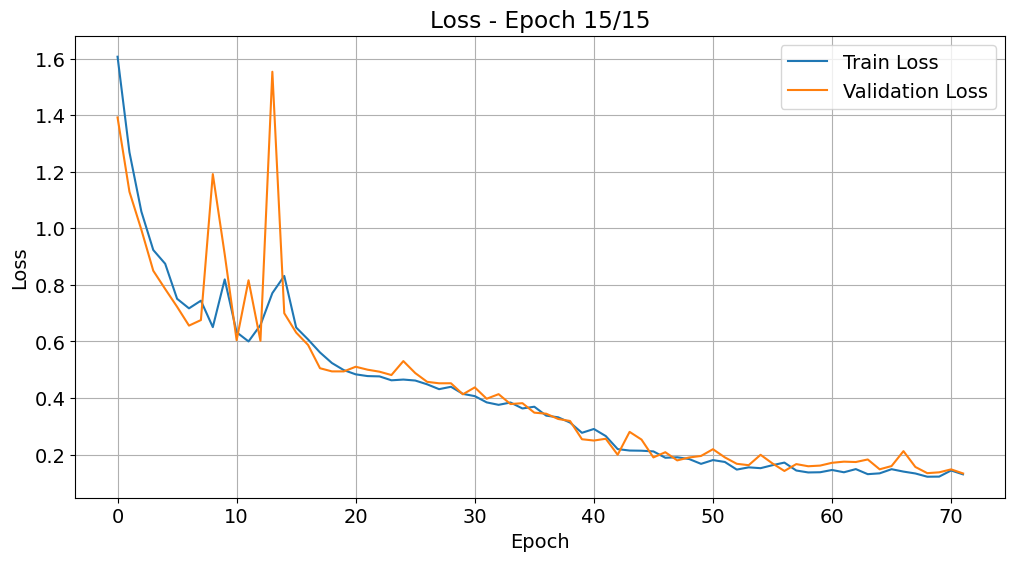

Epoch 15/15: Train Loss = 0.130, Validation Loss = 0.133


In [199]:
train(model=model, 
      n_epochs=15,
      loss_history=loss_history,
      train_loader=train_loader,
      valid_loader=valid_loader,
      best_model_params=best_model_params)

In [195]:
def test(model, test_loader):
    sm = nn.Softmax(dim=1)
    model.eval()
    corr_preds = 0
    total_preds = 0
    test_loader_tqdm = tqdm(test_loader, 
                            desc='Testing',
                            leave=False)    
    with torch.no_grad():
        for features, targets in test_loader_tqdm:
            logits = model(features)
            probs = sm(logits)
            _, pred_labels = torch.max(probs, dim=1)
            corr_preds += (pred_labels == targets).sum().item()
            total_preds += targets.size(0)
    
    acc = corr_preds / total_preds
    print(f"Test Accuracy: {acc * 100:.3f}%")

In [200]:
test(model=model, test_loader=test_loader)

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Test Accuracy: 90.872%


### Part 5. Dogs classification
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Требуется добиться accuracy > 93%

In [ ]:
# Your experiments here